In [1]:
"""
References: 
1) https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
2) https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
3) King's College London Keras Instruction Tutorial PDF
""" 

"\nReferences: \n1) https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/\n2) https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/\n3) King's College London Keras Instruction Tutorial PDF\n"

In [2]:
#change width of Jupyer Notebook to use the whole window
from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))     

C:\Users\cipri\AppData\Local\Temp\ipykernel_11756\4283796252.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD

In [4]:
# import libraries to check available training devices
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras import mixed_precision

# list available devices
print(device_lib.list_local_devices())

# GPU performance optimisations - only works with XLA devices on non-windows machines
#tf.function(jit_compile=True)                                   

# makes use of the tensor cores available on RTX cards
#policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
#tf.keras.mixed_precision.experimental.set_policy(policy)

# print compute and variable precision 
#print('Compute dtype: %s' % policy.compute_dtype)
#print('Variable dtype: %s' % policy.variable_dtype)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8375805280339114031
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22385000448
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6800586067923072557
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:31:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [5]:
# load dataset and perform split
def load_dataset():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()                   # load dataset
    
    X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))                   # reshape X_train to have a single channel 28x28 img representation
    X_test  = X_test.reshape((X_test.shape[0], 28, 28, 1))                    # reshape X_test to have a single channel 28x28 img representation
    
    y_train = to_categorical(y_train)                                          # one hot encode train labels
    y_test  = to_categorical(y_test)                                           # one hot encode test labels
        
    return X_train, y_train, X_test, y_test

# process dataset by changing 255 integers to float 0.0-1.0 values
def prep_pixels(train, test):
    train_float = train.astype('float32') / 255.0                              # normalize to range 0-1
    test_float  = test.astype('float32') / 255.0                               # normalize to range 0-1
     
    return train_float, test_float                                             # return normalized images

In [6]:
# CNN network
def define_cnn():
    CNN = Sequential()
    CNN.add(Conv2D(32, (3, 3), 
                   activation='relu', 
                   kernel_initializer='he_uniform', 
                   input_shape=(28, 28, 1)))
    CNN.add(MaxPooling2D((2, 2)))
    CNN.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    CNN.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    CNN.add(MaxPooling2D((2, 2)))
    CNN.add(Flatten())
    CNN.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    CNN.add(Dense(10, activation='softmax'))
    
    # compile model
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    CNN.compile(optimizer=optimizer, 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    
    # return defined cnn
    return CNN

In [7]:
# evaluate a model using k-fold cross-validation
def evaluate_model(X_data, y_data, n_folds, n_epochs, b_size):
    with tf.device('/device:GPU:0'):
        scores, histories = list(), list()
        kfold = KFold(n_folds, shuffle = True, random_state = 1)                        # prepare cross validation

        for train_ix, test_ix in kfold.split(X_data):                                 # enumerate splits
            cnn_model = define_cnn()                                                  # define model

            X_train, y_train = X_data[train_ix], y_data[train_ix]                    # select rows for training
            X_test, y_test   = X_data[test_ix], y_data[test_ix]                      # select rows for testing

            # fit model
            history = cnn_model.fit(X_train, y_train, 
                                    epochs = n_epochs, 
                                    batch_size = b_size, 
                                    validation_data=(X_test, y_test), 
                                    verbose=1)
            # evaluate model
            _, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
            print('> %.3f' % (acc * 100.0))

            # stores scores
            scores.append(acc)
            histories.append(history)
        
    return scores, histories                                                    # return evaluation
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.show()
        
# display performance summary
def summarize_performance(scores):
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % 
          (mean(scores)*100, std(scores)*100, len(scores))) 
    
    plt.boxplot(scores)                                                       # box and whisker plots of results
    plt.show()                                                                # display results

    
def main_code():
    EPOCHS  = 20
    BATCHES = 256
    
    X_train, y_train, X_test, y_test = load_dataset()                            # load dataset
    X_train, X_test = prep_pixels(X_train, X_test)                               # prepare pixel data
    scores, histories = evaluate_model(X_train, y_train, 5, EPOCHS, BATCHES)     # evaluate model
    summarize_diagnostics(histories)                                             # display learning curves
    summarize_performance(scores)                                                # summarize estimated performance


> 98.750
> 98.667
> 98.558
> 99.100
> 98.717


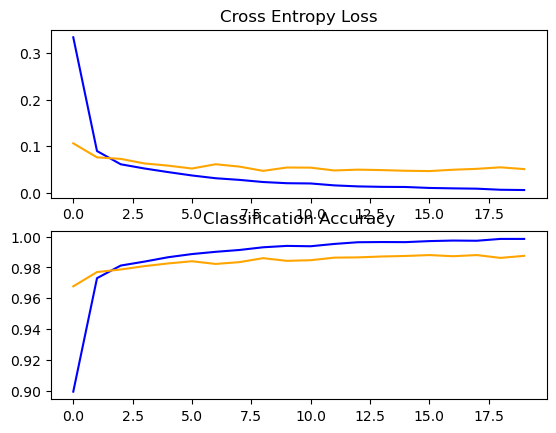

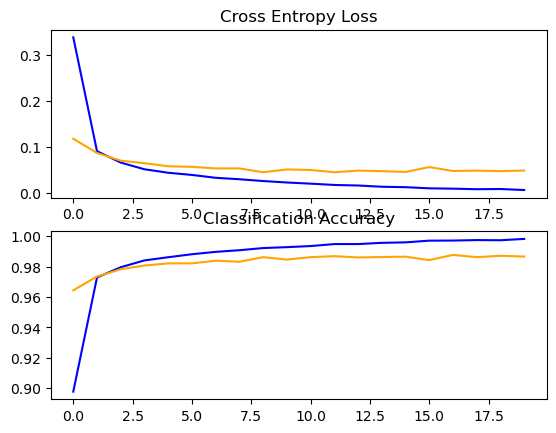

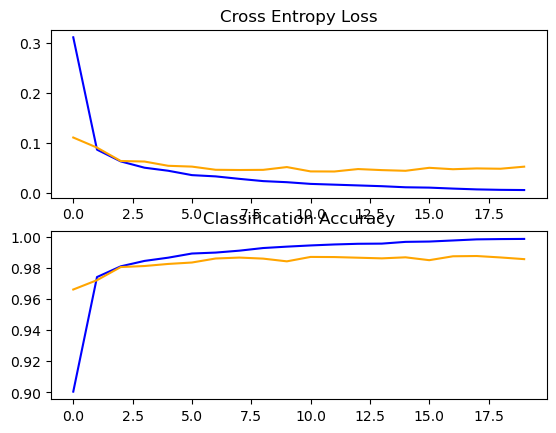

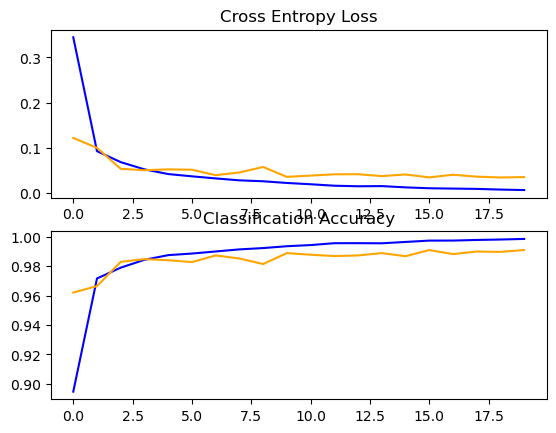

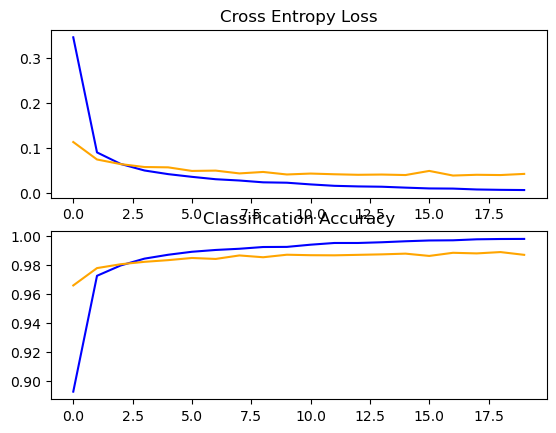

Accuracy: mean=98.758 std=0.183, n=5


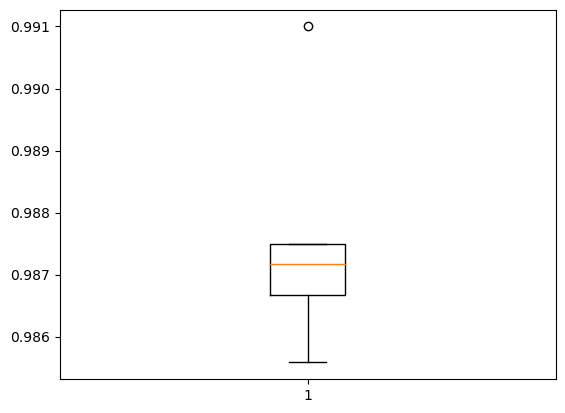

In [8]:
# guard boilerplate
if __name__ == "__main__":     
    main_code()